In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tensorflow.keras.layers import (
                                BatchNormalization, LeakyReLU,
                                Input, Dense, Conv2D,
                                MaxPooling2D, Flatten, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

In [2]:
# set random state for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
K.utils.set_random_seed(42)
# still not reproducible? why?

In [3]:
# negative ratio
RATIO = 1

In [4]:
def make_architecture():
    """
    build model architecture based on miRBind paper

    return a model object
    """
    cnn_num = 6
    kernel_size = 5
    pool_size = 2
    dropout_rate = 0.3
    dense_num = 2

    x = Input(shape=(50,20,1), dtype='float32', name='main_input')
    main_input = x

    for cnn_i in range(cnn_num):
        x = Conv2D(
            filters=32 * (cnn_i + 1),
            kernel_size=(kernel_size, kernel_size),
            padding="same",
            data_format="channels_last",
            name="conv_" + str(cnn_i + 1))(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(pool_size, pool_size), padding='same', name='Max_' + str(cnn_i + 1))(x)
        x = Dropout(rate=dropout_rate)(x)

    x = Flatten(name='2d_matrix')(x)

    for dense_i in range(dense_num):
        neurons = 32 * (cnn_num - dense_i)
        x = Dense(neurons)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=dropout_rate)(x)

    main_output = Dense(1, activation='sigmoid', name='main_output')(x)

    m = K.Model(inputs=[main_input], outputs=[main_output], name='arch_00')
    
    return m

In [5]:
def compile_model():
    K.backend.clear_session()
    m = make_architecture()
    
    opt = Adam(
        learning_rate=0.00152,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam")

    m.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
        )
    return m

In [6]:
def plot_history(history):
    """
    plot history of the model training,
    accuracy and loss of the training and validation set
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6), dpi=80)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.savefig(f"training_acc_1_{RATIO}.jpg")
    
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.savefig(f"training_loss_1_{RATIO}.jpg")

In [7]:
class DataGenerator(Sequence):
    # Loads the data from the numpy files and prepares it for training
    def __init__(self, data_path, labels_path, batch_size, validation_split=0.1, is_validation=False, shuffle=True):
        # preload the encoded numpy data
        self.size = 0
        if RATIO == 1:
            self.size = 2524246
        elif RATIO == 10:
            self.size = 13883353
        elif RATIO == 100:
            self.size = 127476014
            
        self.data = np.memmap(data_path, dtype='float32', mode='r', shape=(self.size, 50, 20, 1))
        self.labels = np.memmap(labels_path, dtype='float32', mode='r', shape=(self.size,))
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Determine number of train and validation samples
        self.validation_split = validation_split
        self.num_samples = len(self.data)
        self.num_validation_samples = int(self.num_samples * validation_split)
        self.num_train_samples = self.num_samples - self.num_validation_samples
        
        # Determine indices for validation and training
        indices = np.arange(self.num_samples)
        if shuffle:
            np.random.shuffle(indices)
        
        if is_validation:
            self.indices = indices[self.num_train_samples:]
        else:
            self.indices = indices[:self.num_train_samples]
        
        # Shuffle the data initially
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.ceil(len(self.indices) / float(self.batch_size)))

    def __getitem__(self, idx):
        # Generate one batch of data
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_data = self.data[batch_indices]
        batch_labels = self.labels[batch_indices]
        return batch_data, batch_labels

    def on_epoch_end(self):
        # Updates indices after each epoch for shuffling
        if self.shuffle:
            np.random.shuffle(self.indices)

### Load dataset

In [8]:
train_data_gen = DataGenerator(f"Manakov2022_{RATIO}_train_dataset.npy", f"Manakov2022_{RATIO}_train_labels.npy", batch_size=32, validation_split=0.1, is_validation=False)

val_data_gen = DataGenerator(f"Manakov2022_{RATIO}_train_dataset.npy", f"Manakov2022_{RATIO}_train_labels.npy", batch_size=32, validation_split=0.1, is_validation=True)

## Prepare model

In [9]:
model = compile_model()
model.summary()

Model: "arch_00"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 50, 20, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 50, 20, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 20, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 50, 20, 32)        128       
 Normalization)                                                  
                                                                 
 Max_1 (MaxPooling2D)        (None, 25, 10, 32)        0         
                                                                 
 dropout (Dropout)           (None, 25, 10, 32)        0         
                                                           

2024-08-09 12:01:27.585010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43440 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:27:00.0, compute capability: 8.6


 Max_2 (MaxPooling2D)        (None, 13, 5, 64)         0         
                                                                 
 dropout_1 (Dropout)         (None, 13, 5, 64)         0         
                                                                 
 conv_3 (Conv2D)             (None, 13, 5, 96)         153696    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 13, 5, 96)         0         
                                                                 
 batch_normalization_2 (Bat  (None, 13, 5, 96)         384       
 chNormalization)                                                
                                                                 
 Max_3 (MaxPooling2D)        (None, 7, 3, 96)          0         
                                                                 
 dropout_2 (Dropout)         (None, 7, 3, 96)          0         
                                                                 
 conv_4 (C

## Train model

In [ ]:
model_history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=10,
    class_weight={0: 1, 1: RATIO}
)

Epoch 1/10


2024-08-09 12:01:36.237326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inarch_00/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-09 12:01:38.567416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-08-09 12:01:38.856255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-09 12:01:38.902920: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55aa14cdd7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-09 12:01:38.902962: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-08-09 12:01:38.909208: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabl

 163766/3585263 [>.............................] - ETA: 34:47:57 - loss: 0.5216 - accuracy: 0.9000

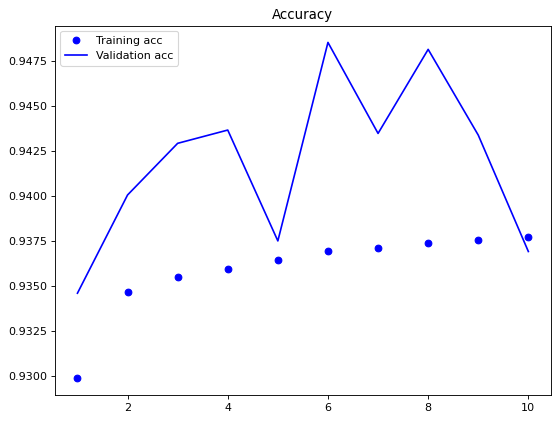

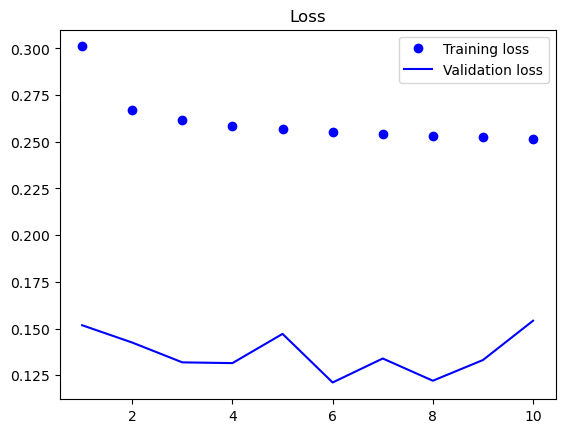

In [12]:
plot_history(model_history)

In [13]:
model.save(f"model_Manakov22_{RATIO}.keras")